In [1]:
"""
The Autonomous Cooperative Consensus Orbit Determination (ACCORD) framework.
Author: Beth Probert
Email: beth.probert@strath.ac.uk

Copyright (C) 2025 Applied Space Technology Laboratory

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

"""

import json
import numpy as np
from datetime import datetime, timedelta
from src.consensus_mech import ConsensusMechanism
from src.dag import DAG
from src.satellite_node import SatelliteNode
from src.transaction import Transaction, TransactionMetadata
from src.utils import load_json_data


# Tester demo function
def run_consensus_test():
    # Number of transactions must be >= 3 for consensus to be possible
    n_tx = 3
    print("=== Running Consensus Test ===")

    # Load observation data from your JSON file
    satellites = load_json_data("od_data.json")
    if not satellites:
        print("No satellite data found.")
        return

    # Setup
    test_satellite = SatelliteNode(node_id="SAT-001")
    test_dag = DAG()
    base_sat = satellites[0]

    # Add other transactions with some random noise
    # TODo - test with bigger variants
    for i in range(n_tx):
        # Simulate noise in observation
        noise = {
            "mean_motion": np.random.normal(0, 0.01),       # rev/day
            "eccentricity": np.random.normal(0, 0.00002),    # unitless
            "inclination": np.random.normal(0, 0.05),        # degrees
            "epoch_jitter": np.random.normal(0, 2)           # seconds
        }

        observed_epoch = base_sat.epoch.utc_datetime() + timedelta(seconds=noise["epoch_jitter"])

        dummy_tx = Transaction(
            sender_address=f"NODE-{i}",
            recipient_address="GROUND",
            sender_private_key="dummy_key",
            metadata=TransactionMetadata(),
            tx_data=json.dumps({
                "OBJECT_NAME": base_sat.name,
                "OBJECT_ID": 25544,
                "EPOCH": observed_epoch.isoformat() + "Z",
                "MEAN_MOTION": ((base_sat.model.no_kozai / (2 * np.pi)) * 1440) + noise["mean_motion"],
                "ECCENTRICITY": base_sat.model.ecco + noise["eccentricity"],
                "INCLINATION": (base_sat.model.inclo * 180 / np.pi) + noise["inclination"]
            })
        )
        test_dag.add_tx(dummy_tx)

    test_transaction = Transaction(sender_address=test_satellite.id,
                                   recipient_address="GROUND",
                                   sender_private_key="dummy_key",
                                   metadata=TransactionMetadata(),
                                   tx_data="")

    # Init PoISE mechanism
    poise = ConsensusMechanism()

    # Run consensus on a single satellite observation
    consensus_result = poise.proof_of_inter_satellite_evaluation(
        dag=test_dag,
        sat_node=test_satellite,
        transaction=test_transaction
    )

    # Output result
    print(f"\nConsensus reached: {consensus_result}")
    print(f"Updated Node Reputation: {test_satellite.reputation:.2f}")
    print(f"Transaction:\n{test_transaction}")
    print(test_dag.ledger)
    return test_dag

test_dag = run_consensus_test()


=== Running Consensus Test ===

Consensus reached: True
Updated Node Reputation: 0.10
Transaction:
Transaction(
  sender_address=SAT-001,
  recipient_address=GROUND,
  timestamp=2025-07-29 15:16:20.560938,
  tx_data='{"OBJECT_NAME": "ISS (ZARYA)", "OBJECT_ID": 25544, "EPOCH": "2024-05-06T19:53:05Z", "MEAN_MOTION": 15.509576740000002, "ECCENTRICITY": 0.000358, "INCLINATION": 51.639300000000006}',
  consensus_reached=True,
  is_confirmed=False,
  is_rejected=False,
  confirmation_score=0.1,
  parent_hashes=['3ff77c1a7e2b8477e26ec97c03ec331a967cc5cc94c57718d12f713af5735994', 'Genesis Transaction 2'],
  hash=d7faee2ea5...)

{'Genesis Transaction 1': [Transaction(
  sender_address=0,
  recipient_address=0,
  timestamp=2025-07-29 15:16:20.560938,
  tx_data='Genesis Transaction 1',
  consensus_reached=True,
  is_confirmed=True,
  is_rejected=False,
  confirmation_score=0.0,
  parent_hashes=[],
  hash=45206b38ce...)
], 'Genesis Transaction 2': [Transaction(
  sender_address=0,
  recipient_addr

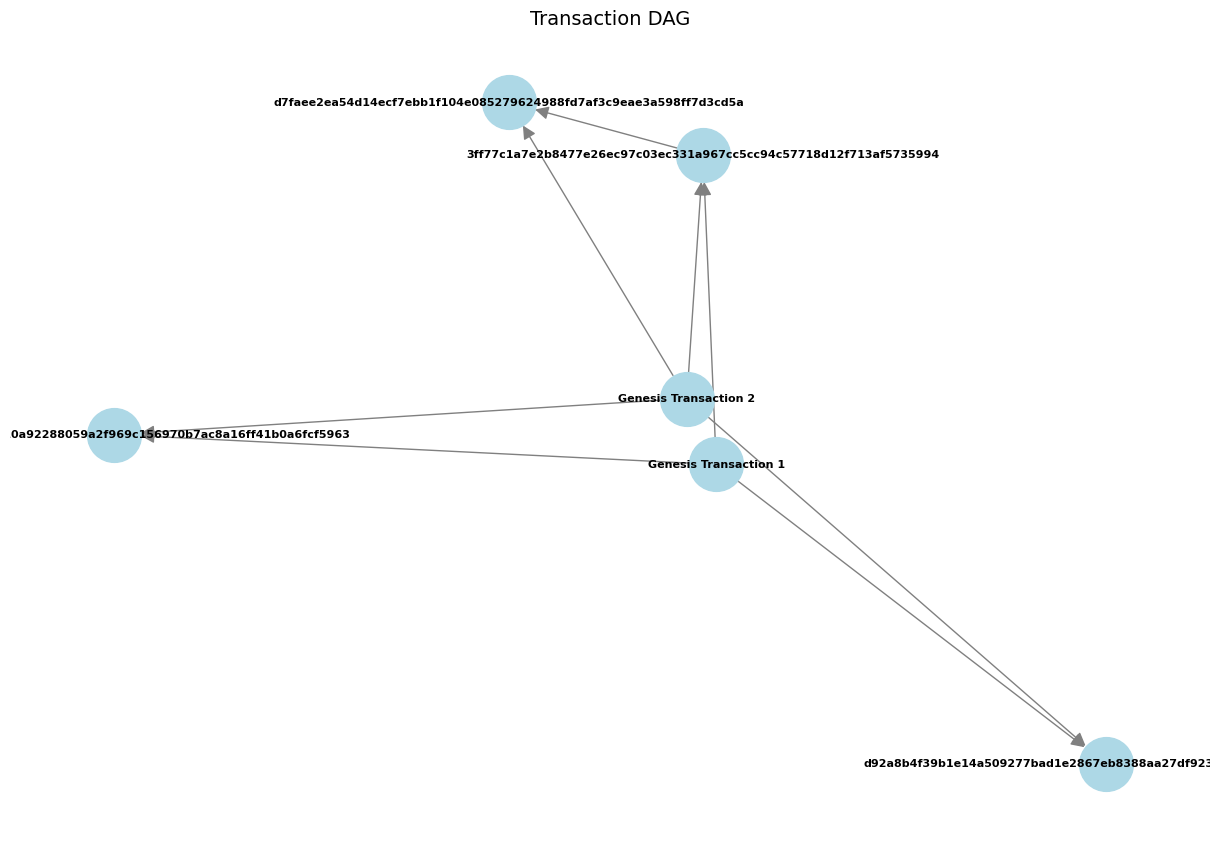

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_transaction_dag(dag):
    G = nx.DiGraph()

    # Flatten the DAG ledger
    for key, tx_list in dag.ledger.items():
        for tx in tx_list:
            G.add_node(key, label=key or "tx")

            for parent_hash in tx.metadata.parent_hashes:
                G.add_edge(key, parent_hash)

    # Choose a layout
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=1500, font_size=8, font_weight='bold',
            edge_color='gray', arrowsize=20)

    plt.title("Transaction DAG", fontsize=14)
    plt.show()

plot_transaction_dag(test_dag)